# MLE and errors

In [184]:
import sys
sys.path.append("D:/Master/Blok3/AAS/")
import numpy as np
from scipy import integrate, stats, interpolate
from toolbox import vis
from toolbox import as_toolbox as ast
import urllib
import matplotlib.pyplot as plt
import importlib as iml
import toolbox as tb
import emcee
from numba import njit

# Ex. 1 

# Ex. 2 

In [3]:
len_chain = 100
x_i = 100
x_i2 = -27
X = np.empty(len_chain)
X2 = np.empty(len_chain)
X[0] = x_i
X2[0] = x_i2
for i in range(len_chain-1):
        X[i+1] = stats.norm.rvs(loc = X[i]/2, scale =1)
        X2[i+1] = stats.norm.rvs(loc = X2[i]/2, scale =1)

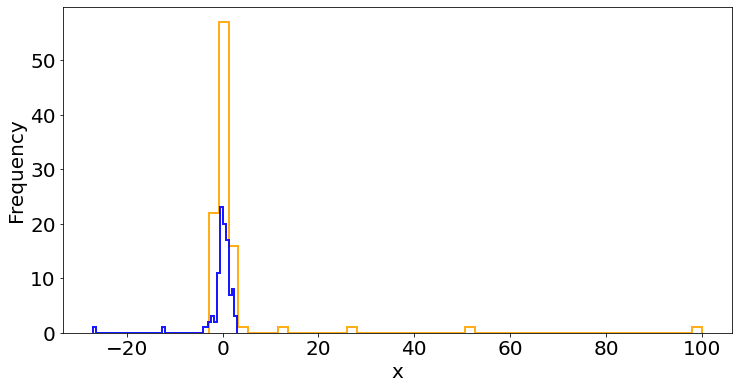

In [4]:
fd = vis.nice_histogram(X, 50, show_plot=False)
fd = vis.nice_histogram(X2, 50, show_plot=False, figure = fd['fig'], axis = fd['ax'],
                                              color_hist='blue')
fd['fig']

(0.0, 20.0)

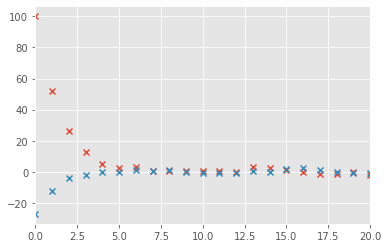

In [5]:
plt.scatter(np.arange(len_chain), X, marker='x')
plt.scatter(np.arange(len_chain), X2, marker='x')
plt.xlim(0,20)
#plt.yscale('log')

In [255]:
alpha = 6
beta = 17
n = 100
observed = 66
def f_prior(theta,a = alpha ,b = beta): return stats.beta.pdf(theta, a, b)
def f_lh(theta, k = observed, n = n): return stats.binom.pmf(k, n, theta)
def f_posterior(theta): return f_prior(theta)*f_lh(theta) #no normalization so far
def f_proposal(mu = 0, sig = .4, size = 1): return stats.norm.rvs(loc = mu, scale = sig, size = size)

In [256]:
def MC(post, prop, num_iter, theta0):
    Theta = np.empty(num_iter)
    theta = theta0
    for i in range(num_iter):
        theta_prop = theta+prop()
        rand = np.random.uniform()
        if post(theta_prop)/post(theta)>rand:
            theta = theta_prop
            Theta[i] = theta
        else:
            Theta[i] = theta    
    return Theta

In [257]:
def MCMH(post, prop, Theta0, num_iter = 1000, nwalkers = 10, burn_in = 500):
    """Performs the Monte_Carlo Metropolis Hasting algorithm for a 1d function.
        prop: proposal function, should take only size as argument
        Theta0: initial guess float or array"""
    if num_iter<burn_in:
        raise ValueError('num_iter should be larger than burn_in')
    if type(Theta0==float) or type(Theta0==int):
        Theta0 = Theta0*np.ones(nwalkers)
    Theta_arr = np.empty((num_iter,nwalkers))
    for i in range(num_iter):
        Theta_prop = Theta0+prop(size = nwalkers)
        rand = np.random.uniform(size = nwalkers)
        accept_mask = post(Theta_prop)/post(Theta0)>rand
        Theta0[accept_mask] = Theta_prop[accept_mask]
        Theta_arr[i, accept_mask] = Theta0[accept_mask]
        Theta_arr[i, ~accept_mask] = Theta0[~accept_mask]
    Theta_arr = Theta_arr[burn_in:,:].reshape(-1)
    return Theta_arr

In [263]:
nwalkers = 10
Theta_fin = MCMH(f_posterior, f_proposal, stats.norm.rvs(loc = .6, scale = .3,size = nwalkers) ,
                 burn_in=50, nwalkers=nwalkers, num_iter = 1000)

In [168]:
%time Theta = MC(f_posterior, f_proposal, 2000, .5)

Wall time: 5.85 s


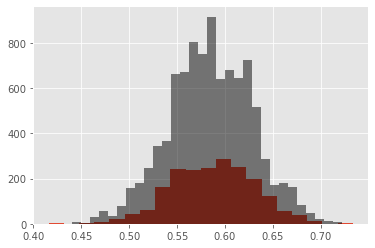

In [264]:
_ =plt.hist(Theta, 20)
_ = plt.hist(Theta_fin, 30, alpha = .5, color = 'k')

In [260]:
#np.mean(Theta[2000:]), np.std(Theta[2000:])

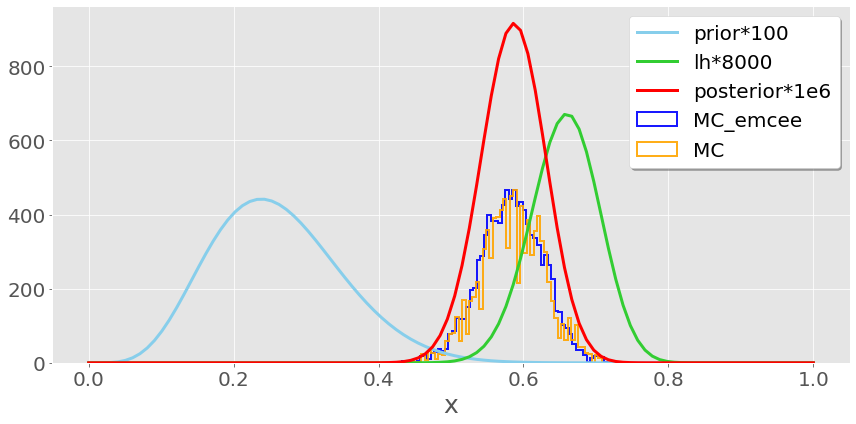

In [265]:
fd = vis.nice_histogram(chain, 60,  plot_legend=False, show_plot=False, plot_hist=True, 
                                             data_label_hist= 'MC_emcee', color_hist= 'blue')
fd = vis.nice_histogram(Theta_fin, 60,  plot_legend=False, show_plot=False, plot_hist=True, 
                                             data_label_hist= 'MC', figure = fd['fig'], axis = fd['ax'])

theta_x = np.linspace(0,1,100)
fig,ax = vis.nice_plot(theta_x, 100*f_prior(theta_x), axis = fd['ax'], figure = fd['fig'], data_label='prior*100')
fig, ax = vis.nice_plot(theta_x, 8000*f_lh(theta_x), axis = ax, figure = fig, data_label='lh*8000', color = 'limegreen')
fig, ax = vis.nice_plot(theta_x, 1.5e6*f_posterior(theta_x), axis = ax, figure = fig, 
                        data_label='posterior*1e6', color = 'r', plot_legend=True)
fig

## Do the same thing with emce

In [266]:
#for n dimensions we can use emcee

In [221]:
nwalkers = 10
def log_prob(theta): return np.log(f_posterior(theta))
p0 = 0.5 + np.random.uniform(size = (nwalkers,1))/10
sampler = emcee.EnsembleSampler(nwalkers, 1, log_prob)
_ = sampler.run_mcmc(p0, 1000)

In [222]:
chain = sampler.get_chain(flat = True)

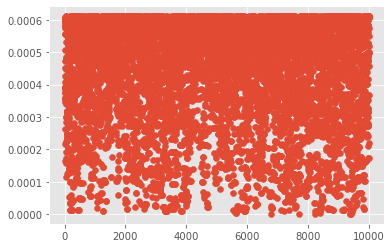

In [223]:
plt.scatter(np.arange(len(chain)), f_posterior(chain))